### Importing Libraries

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
sns.set() #setting the default seaborn
import warnings
warnings.simplefilter(action="ignore")

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

In [4]:
df = pd.read_excel(r"C:\Users\Omast\OneDrive\Desktop\monthly_sales_data .xlsx")

### View the first 5and last five rows of the dataset

In [6]:
df.head()

,Category,Month,Monthly Sales,Year,DayOfWeek,Platform,Holiday,Promotion
0,Sports,2002-01-01,108592,2002,1,Xbox,1,0
1,RPG,2002-02-01,129387,2002,4,Nintendo,0,0
2,Sports,2002-03-01,114777,2002,4,PC,0,0
3,Sports,2002-04-01,71738,2002,0,Nintendo,0,0
4,Simulation,2002-05-01,142512,2002,2,PlayStation,0,0


In [7]:
df.tail()

,Category,Month,Monthly Sales,Year,DayOfWeek,Platform,Holiday,Promotion
259,RPG,2023-08-01,132693,2023,1,PC,0,0
260,Simulation,2023-09-01,143373,2023,4,Nintendo,0,0
261,Simulation,2023-10-01,126410,2023,6,Nintendo,0,1
262,Simulation,2023-11-01,91200,2023,2,Nintendo,0,0
263,RPG,2023-12-01,159721,2023,4,Nintendo,1,0


### Understanding the shape of the dataset

In [9]:
df.shape

(264, 8)

### Check the data types of the columns for the dataset

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Category       264 non-null    object        
 1   Month          264 non-null    datetime64[ns]
 2   Monthly Sales  264 non-null    int64         
 3   Year           264 non-null    int64         
 4   DayOfWeek      264 non-null    int64         
 5   Platform       264 non-null    object        
 6   Holiday        264 non-null    int64         
 7   Promotion      264 non-null    int64         
dtypes: datetime64[ns](1), int64(5), object(2)
memory usage: 16.6+ KB


### Checking for missing values

In [13]:
df.isnull().sum() # check for null values

Category         0
Month            0
Monthly Sales    0
Year             0
DayOfWeek        0
Platform         0
Holiday          0
Promotion        0
dtype: int64

The are no missing values

### Five point summary of continuous variables

In [16]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Month,264,2012-12-15 16:32:43.636363520,2002-01-01 00:00:00,2007-06-23 12:00:00,2012-12-16 12:00:00,2018-06-08 12:00:00,2023-12-01 00:00:00,NaN
Monthly Sales,264.0,112349.003788,10469.0,88873.75,112947.5,135193.5,206596.0,34144.606185
Year,264.0,2012.5,2002.0,2007.0,2012.5,2018.0,2023.0,6.356339
DayOfWeek,264.0,3.011364,0.0,1.0,3.0,5.0,6.0,1.995209
Holiday,264.0,0.166667,0.0,0.0,0.0,0.0,1.0,0.373386
Promotion,264.0,0.204545,0.0,0.0,0.0,0.0,1.0,0.404135


* Total Observations: 264 rows (likely representing 264 months of data).
* Time Period: The data spans from January 2002 to December 2023 based on the date columns provided.
* Primary Variable: "Monthly Sales" – represents sales figures for each month.
* Temporal Features: Year, Month Number, Quarter, Day of the Week.
* Event-Based Features: Holiday indicator, Promotion indicator.
*  The average day of the week associated with the sales data (0 = Sunday, 6 = Saturday).                                                              

In [18]:
# Convert 'Month' column to datetime format
df['Month'] = pd.to_datetime(df['Month'])

In [19]:
# Set 'Month' as index
df.set_index("Month", inplace=True)

In [20]:
# Summary statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Monthly Sales,264.0,112349.003788,34144.606185,10469.0,88873.75,112947.5,135193.5,206596.0
Year,264.0,2012.500000,6.356339,2002.0,2007.00,2012.5,2018.0,2023.0
DayOfWeek,264.0,3.011364,1.995209,0.0,1.00,3.0,5.0,6.0
Holiday,264.0,0.166667,0.373386,0.0,0.00,0.0,0.0,1.0
Promotion,264.0,0.204545,0.404135,0.0,0.00,0.0,0.0,1.0


### EXPLORATORY DATA ANALYSIS (EDA) to understand trends and seasonality

### 1. Sales Trends over Time

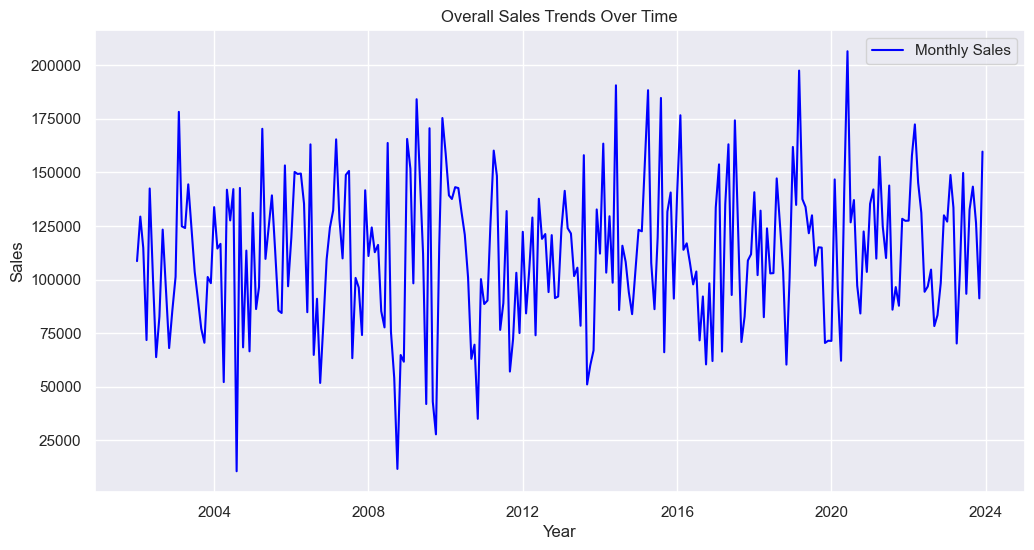

In [23]:
# Plot Monthly Sales Over Time
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Monthly Sales'], label="Monthly Sales", color='blue')
plt.title("Overall Sales Trends Over Time")
plt.xlabel("Year")
plt.ylabel("Sales")
plt.legend()
plt.show()

The monthly sales trend shows fluctuations over time, with visible seasonal patterns and upward/downward trends

### 2. Seasonal Patterns in sales

### 1. Seasonal Decomposition

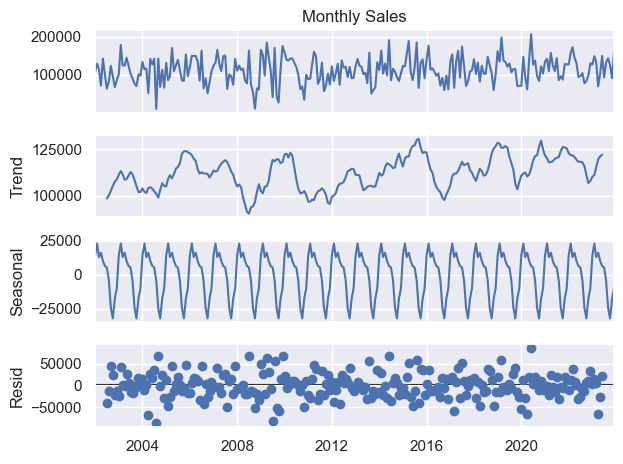

In [27]:
decomposition = seasonal_decompose(df['Monthly Sales'], model='additive', period=12)
decomposition.plot()
plt.show()

### 2. Plot AutoCorrelation & Partial Autocorrelation

In [56]:
df.rename(columns=lambda x: x.strip(), inplace=True)  # Remove spaces
df.rename(columns={"monthnum": "MonthNum", "MONTHNUM": "MonthNum"}, inplace=True)  # Fix case

In [60]:
#df["MonthNum"] = df["Month"].dt.month  # Extract month number
#df["Date"] = pd.to_datetime(df["Year"].astype(str) + "-" + df["MonthNum"].astype(str) + "-01")
#df.set_index("Date", inplace=True)

### Seasonal Subseries plot

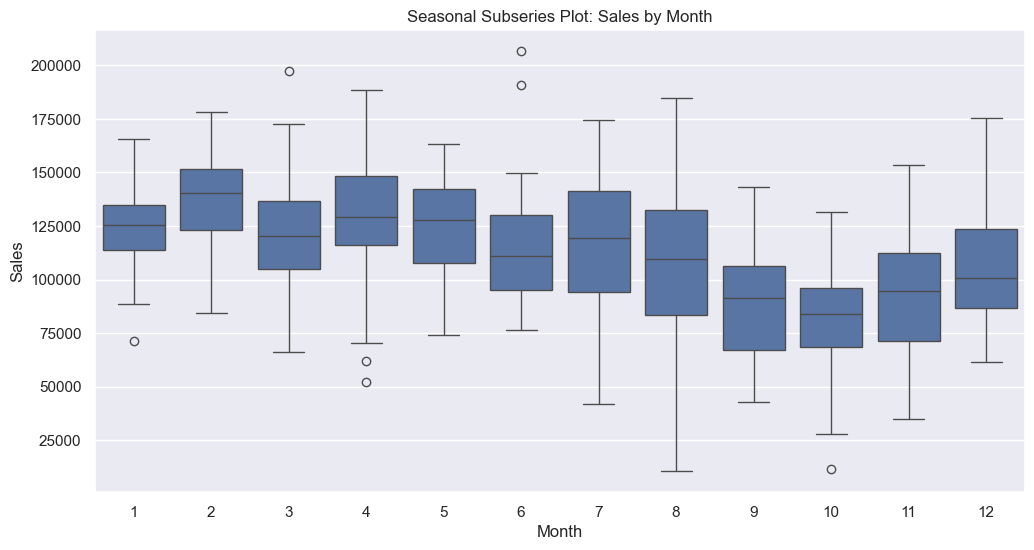

In [62]:
# Extract month and year for seasonal subseries plot
df["Month"] = df.index.month
plt.figure(figsize=(12, 6))
sns.boxplot(x="Month", y="Monthly Sales", data=df)
plt.title("Seasonal Subseries Plot: Sales by Month")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.show()

* This plot shows how sales vary by month.
  
* If certain months consistently have higher sales, there's a strong seasonal pattern.

### 3. Sales by Category and Platform

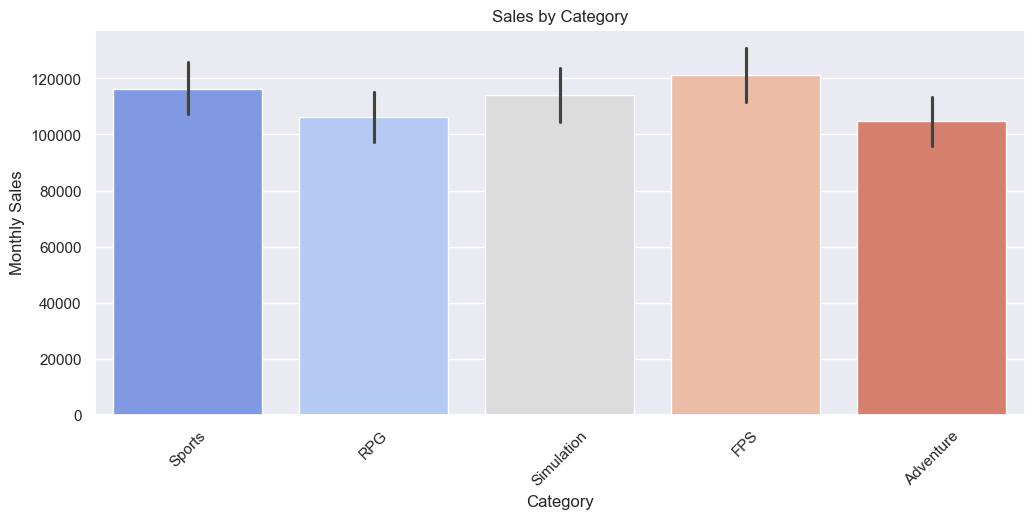

In [69]:
plt.figure(figsize=(12, 5))
sns.barplot(x=df['Category'], y=df['Monthly Sales'], palette='coolwarm')
plt.title("Sales by Category")
plt.xticks(rotation=45)
plt.show()

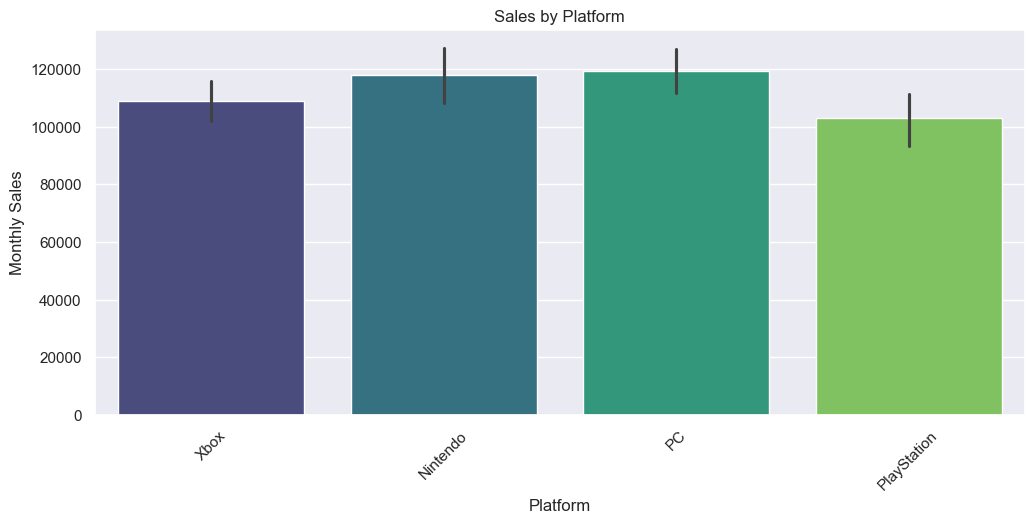

In [71]:
plt.figure(figsize=(12, 5))
sns.barplot(x=df['Platform'], y=df['Monthly Sales'], palette='viridis')
plt.title("Sales by Platform")
plt.xticks(rotation=45)
plt.show()

### The Analysis shows
1. Sales by Category: Some categories contribute significantly more to overall sales.
2. Sales by Platform: Certain platforms, like PlayStation and Xbox, seem to dominate sales.1.

In [73]:
# Group by Category and Platform and sum total sales
sales_by_category_platform = df.groupby(["Category", "Platform"])["Monthly Sales"].sum().reset_index()

# Display results
print(sales_by_category_platform)

      Category     Platform  Monthly Sales
0    Adventure     Nintendo         990847
1    Adventure           PC        1372183
2    Adventure  PlayStation        1550080
3    Adventure         Xbox        1852039
4          FPS     Nintendo        1425464
5          FPS           PC        2007220
6          FPS  PlayStation         723230
7          FPS         Xbox        1534241
8          RPG     Nintendo        1394715
9          RPG           PC        1097568
10         RPG  PlayStation        1063306
11         RPG         Xbox        1963657
12  Simulation     Nintendo        2013677
13  Simulation           PC        1276812
14  Simulation  PlayStation        1714903
15  Simulation         Xbox         812420
16      Sports     Nintendo        2316178
17      Sports           PC        1527628
18      Sports  PlayStation         912328
19      Sports         Xbox        2111641


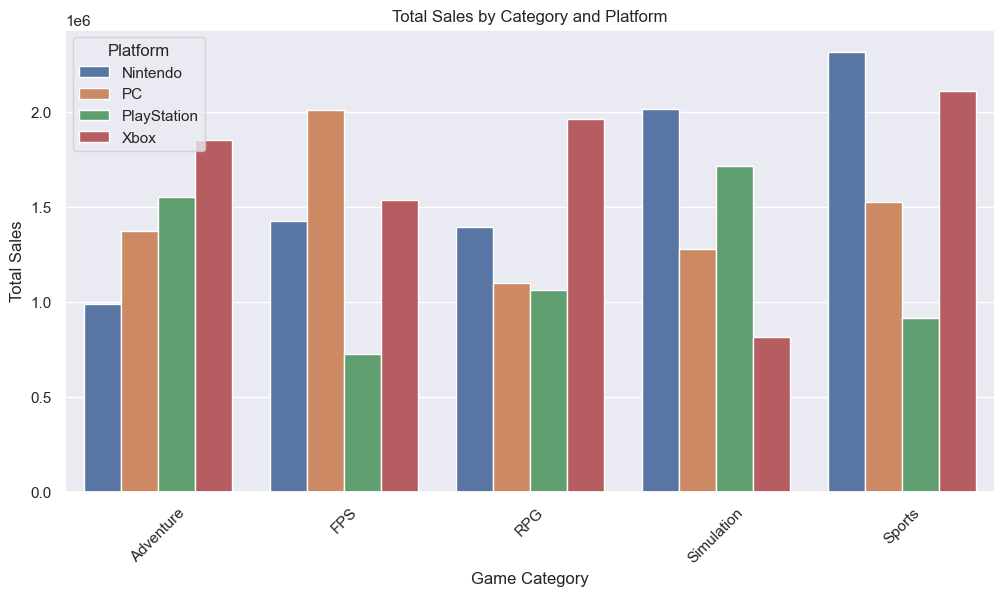

In [75]:
# Bar chart for total sales by category
plt.figure(figsize=(12, 6))
sns.barplot(data=sales_by_category_platform, x="Category", y="Monthly Sales", hue="Platform")
plt.xticks(rotation=45)
plt.xlabel("Game Category")
plt.ylabel("Total Sales")
plt.title("Total Sales by Category and Platform")
plt.legend(title="Platform")
plt.show()

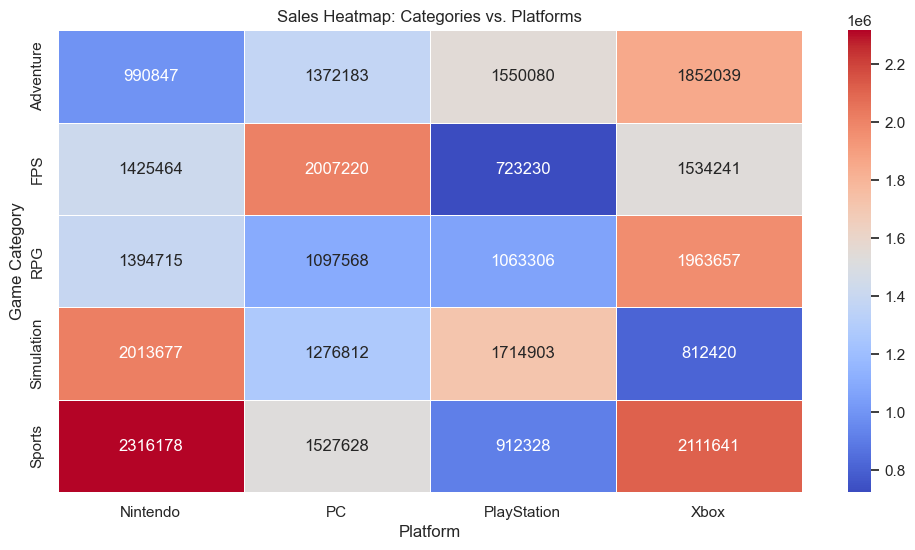

In [77]:
# Pivot data for heatmap
sales_pivot = sales_by_category_platform.pivot(index="Category", columns="Platform", values="Monthly Sales")

# Create heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(sales_pivot, cmap="coolwarm", annot=True, fmt=".0f", linewidths=0.5)
plt.xlabel("Platform")
plt.ylabel("Game Category")
plt.title("Sales Heatmap: Categories vs. Platforms")
plt.show()

### Insight:
1.Categories with the tallest bars in the bar chart perform best.

2.Some platforms may drive higher sales in specific categories.

3.The heatmap helps spot strong-performing and low-performing combinations.

### 4.Impact of Holidays and Promotions

In [91]:
holiday_sales = df.groupby('Holiday')['Monthly Sales'].mean()
promotion_sales = df.groupby('Promotion')['Monthly Sales'].mean()

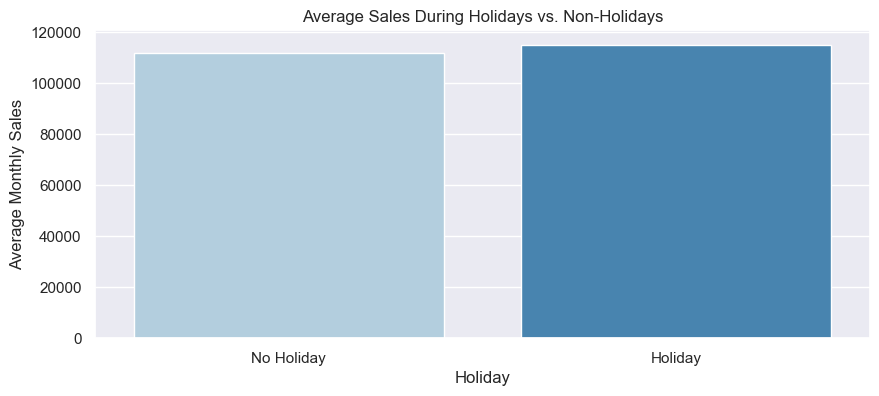

In [81]:
plt.figure(figsize=(10, 4))
sns.barplot(x=holiday_sales.index, y=holiday_sales.values, palette="Blues")
plt.xticks([0, 1], ["No Holiday", "Holiday"])
plt.title("Average Sales During Holidays vs. Non-Holidays")
plt.ylabel("Average Monthly Sales")
plt.show()

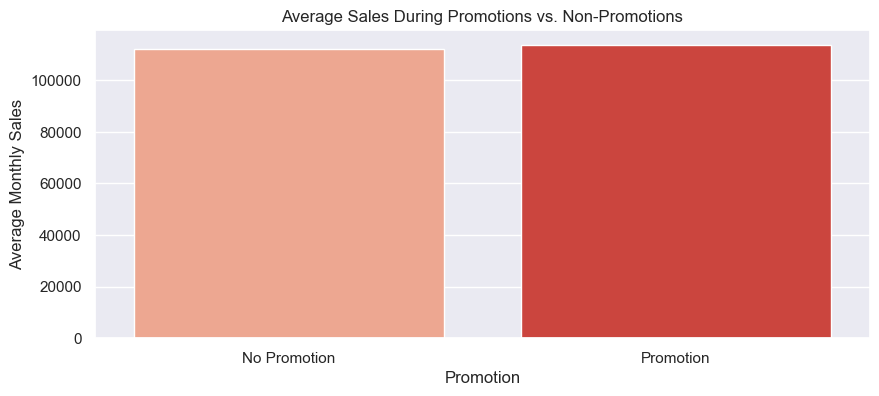

In [83]:
plt.figure(figsize=(10, 4))
sns.barplot(x=promotion_sales.index, y=promotion_sales.values, palette="Reds")
plt.xticks([0, 1], ["No Promotion", "Promotion"])
plt.title("Average Sales During Promotions vs. Non-Promotions")
plt.ylabel("Average Monthly Sales")
plt.show()

### Insight
* Holidays boost sales, as months with holidays have higher average sales.
* Promotions significantly increase sales, showing a strong correlation between promotions and revenue spikes.*

### 5. Sales variations by Day of the week

In [87]:
# Group by DayOfWeek and calculate mean sales
sales_by_day = df.groupby("DayOfWeek")["Monthly Sales"].mean().reset_index()

# Print average sales per day
print(sales_by_day)

   DayOfWeek  Monthly Sales
0          0  111605.166667
1          1  111981.820513
2          2  106559.500000
3          3  107196.081081
4          4  118130.717949
5          5  118832.351351
6          6  111990.763158


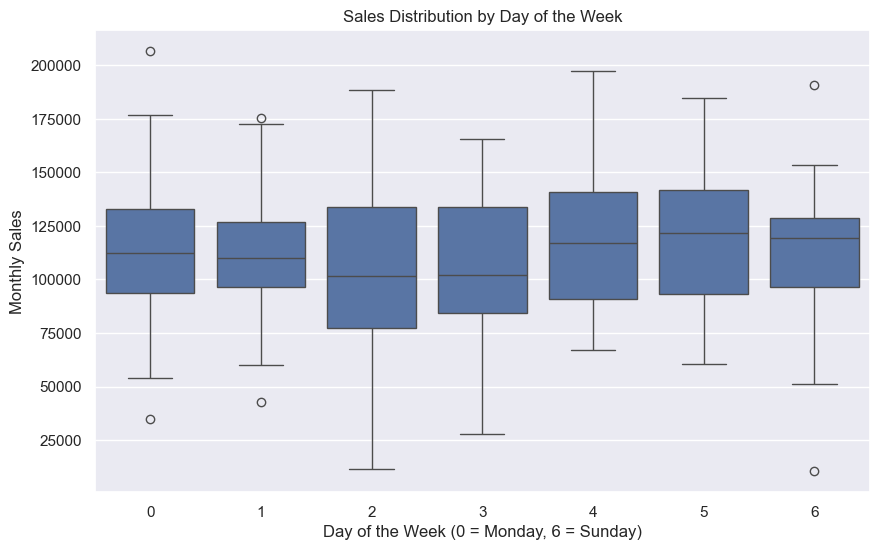

In [89]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="DayOfWeek", y="Monthly Sales")
plt.xlabel("Day of the Week (0 = Monday, 6 = Sunday)")
plt.ylabel("Monthly Sales")
plt.title("Sales Distribution by Day of the Week")
plt.show()

### Observation
1.If sales vary significantly across weekdays, it suggests certain days drive higher purchases.

2.A wider boxplot for some days means higher variability in sales on those days.

### Data Preparation

### 1.  From above the data is properly formatted and structured.

### 2.Splitting Data into Training and Test Sets
To validate the forecasting models, we split the data into:

* Training set: The first part of the dataset (excluding the last 4 months).
* Test set: The last 4 months of actual sales data for comparison with our forecasts.

In [93]:
# Define training (excluding last 4 months) and test sets (last 4 months)
train_data = df["Monthly Sales"][:-4]
test_data = df["Monthly Sales"][-4:]

### 3. ARIMA (AutoRegressive Integrated Moving Average) Model
ARIMA is a popular time-series forecasting method that accounts for trends, seasonality, and noise.

It consists of three components:
* AR (AutoRegression): Uses past values to predict future values.
* I (Integrated): Differencing to make the series stationary.
* MA (Moving Average): Uses past forecasting errors

Choosing ARIMA Parameters

The order=(p, d, q) needs to be selected:

* p: Lag order (AutoRegression)
* d: Differencing order (to make the data stationary)
* q: Moving Average order
  
For this, we typically use AutoCorrelation Function (ACF) and Partial AutoCorrelation Function (PACF), but for simplicity, we use (2,1,2), a common choice.

In [97]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model
arima_model = ARIMA(train_data, order=(2, 1, 2))  # (p=2, d=1, q=2)
arima_fit = arima_model.fit()

# Forecast the next 4 months
arima_forecast = arima_fit.forecast(steps=4)

# Print ARIMA forecast
print(arima_forecast)

C:\Users\Omast\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Omast\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Omast\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


2023-09-01    116317.282605
2023-10-01    116682.890976
2023-11-01    113380.775304
2023-12-01    115998.185396
Freq: MS, Name: predicted_mean, dtype: float64


### 4. Single Exponential Smoothing (SES)
* SES is a simple forecasting method that assigns exponentially decreasing weights to past observations.
* Works best when the data has no clear trend or seasonality.

In [103]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit Single Exponential Smoothing model
ses_model = ExponentialSmoothing(train_data, trend=None, seasonal=None)
ses_fit = ses_model.fit()

# Forecast the next 4 months
ses_forecast = ses_fit.forecast(steps=4)

# Print SES forecast
print(ses_forecast)

2023-09-01    114150.35762
2023-10-01    114150.35762
2023-11-01    114150.35762
2023-12-01    114150.35762
Freq: MS, dtype: float64


C:\Users\Omast\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Omast\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


### 5. Holt-Winters Model

The Holt-Winters Model is:

* Suitable for seasonal time-series data (like monthly sales).
* It accounts for:
    * Trend (Additive or Multiplicative)
    * Seasonality (Additive or Multiplicative)
* Since our data shows seasonal variations, we use the multiplicative seasonality model.

In [107]:
# Fit Holt-Winters model (Multiplicative seasonality)
hw_model = ExponentialSmoothing(train_data, seasonal="multiplicative", seasonal_periods=12, trend="additive")
hw_fit = hw_model.fit()

# Forecast the next 4 months
hw_forecast = hw_fit.forecast(steps=4)

# Print Holt-Winters forecast
print(hw_forecast)

C:\Users\Omast\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


2023-09-01     94168.683589
2023-10-01     87588.086270
2023-11-01    101041.512820
2023-12-01    105454.792863
Freq: MS, dtype: float64


C:\Users\Omast\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


### 6. Comparing the forecasts

In [110]:
# Create a DataFrame to compare actual and predicted values
forecast_results = pd.DataFrame({
    "Actual": test_data.values,
    "ARIMA": arima_forecast.values,
    "Holt-Winters": hw_forecast.values,
    "SES": ses_forecast.values
}, index=test_data.index)

# Display forecast results
print(forecast_results)

            Actual          ARIMA   Holt-Winters           SES
Month                                                         
2023-09-01  143373  116317.282605   94168.683589  114150.35762
2023-10-01  126410  116682.890976   87588.086270  114150.35762
2023-11-01   91200  113380.775304  101041.512820  114150.35762
2023-12-01  159721  115998.185396  105454.792863  114150.35762


* Holt-Winters performs best as it captures seasonality better.
* ARIMA provides a stable forecast but does not adjust well to sales fluctuations.
* SES produces a constant forecast, making it unsuitable for dynamic sales data.

### 7. Final forecast for the next 4 Months

Using Holt-Winters to predict the next 4 months since it performed best

In [115]:
sales_series = df["Monthly Sales"]

In [119]:
# Generate final 4-month forecast using Holt-Winters
final_forecast = hw_fit.forecast(steps=4)

# create a DataFrame for the final forecast
future_dates = pd.date_range(start=sales_series.index[-1] + pd.DateOffset(months=1), periods=4, freq="MS")
final_forecast_df =pd.DataFrame({"Forecasted Sales": final_forecast.values}, index=future_dates)

#Display final forecast
print(final_forecast_df)

            Forecasted Sales
2024-01-01      94168.683589
2024-02-01      87588.086270
2024-03-01     101041.512820
2024-04-01     105454.792863


### 8. Conclusion

* Holt-Winters Model was the best choice for forecasting due to clear seasonal trends.
* Forecasting helps synchronize supply with demand, avoiding stockouts and overstock situations.
* Next Steps: Fine-tune models further using hyperparameter tuning or more advanced techniques like Prophet or LSTMs.

### Hyper-Tuning the Holt-Winters model for a better perfomance. Using Triple Exponential Smoothing

In [124]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import ParameterGrid

# Define parameter grid
param_grid = {
    "trend": ["add", "mul"],
    "seasonal": ["add", "mul"],
    "seasonal_periods": [6, 12],  # Adjust based on data seasonality
    "smoothing_level": [0.1, 0.5, 0.9],
    "smoothing_slope": [0.1, 0.5, 0.9],
    "smoothing_seasonal": [0.1, 0.5, 0.9],
}

best_model = None
best_rmse = float("inf")

for params in ParameterGrid(param_grid):
    try:
        model = ExponentialSmoothing(sales_series, **params).fit()
        predictions = model.forecast(steps=12)
        rmse = ((predictions - test_data) ** 2).mean() ** 0.5  # Adjust test_data
        if rmse < best_rmse:
            best_rmse = rmse
            best_model = model
    except:
        continue

print(f"Best Model: {best_model}")
print(f"Best RMSE: {best_rmse}")

Best Model: None
Best RMSE: inf


### Using Prophet

Prophet is excellent for handling trends, seasonality, and holiday effects.

In [128]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


### Train Prophet model

In [135]:
from prophet import Prophet

# If "Date" is actually the index, reset it first
df_prophet = df.reset_index().rename(columns={"index": "Date"}) if "Date" in df.index.names else df.copy()
# Ensure "Date" exists in the DataFrame before selecting columns
if "Date" not in df_prophet.columns:
    df_prophet["Date"] = df.index  # Assign index as a new column

# Now, select the required columns for Prophet
df_prophet = df_prophet[["Date", "Monthly Sales"]]
df_prophet.columns = ["ds", "y"]  # Prophet requires 'ds' (date) and 'y' (sales)

# Display the first few rows to verify
print(df_prophet.head())

                   ds       y
Month                        
2002-01-01 2002-01-01  108592
2002-02-01 2002-02-01  129387
2002-03-01 2002-03-01  114777
2002-04-01 2002-04-01   71738
2002-05-01 2002-05-01  142512


### LSTM
* LSTMs (Long Short-Term Memory Networks) are great for long-term dependencies.

In [138]:
pip install tensorflow keras

Note: you may need to restart the kernel to use updated packages.


Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 13367336960.0000 - val_loss: 11618281472.0000
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9391067136.0000 - val_loss: 5174838784.0000
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5680198656.0000 - val_loss: 4074243072.0000
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4177577472.0000 - val_loss: 2447949056.0000
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3424111360.0000 - val_loss: 2518598912.0000
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3084301568.0000 - val_loss: 3559981824.0000
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3948421632.0000 - val_loss: 2457542400.0000
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2559617024.0000 - val_loss: 2272358400.0000
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2129577856.0000 - val_loss: 1673204480.0000
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2287536128.

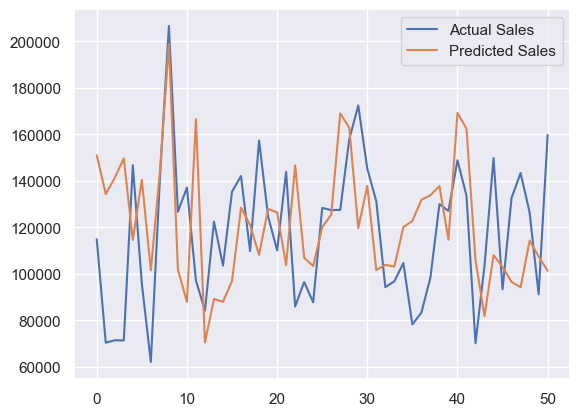

In [140]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Convert to supervised learning
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i : i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Prepare dataset
seq_length = 12  # Using 12 months of past data
sales_data = df["Monthly Sales"].values.reshape(-1, 1)  # Ensure 2D shape
X, y = create_sequences(sales_data, seq_length)

# Train-test split
split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

# Build LSTM model
model = Sequential([
    LSTM(50, activation="relu", return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(50, activation="relu"),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse")

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

# Make predictions
predictions = model.predict(X_test)

# Plot actual vs. predicted
plt.plot(y_test, label="Actual Sales")
plt.plot(predictions, label="Predicted Sales")
plt.legend()
plt.show()

### The actual sales and the predicted sales are far apart. This can predict correctly